In [1]:
# !pip install ipypb
# !pip install openpyxl

In [447]:
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
np.random.seed(0)

import ast
from ipypb import track

import os
from pathlib import Path

from matplotlib import pyplot as plt

# load data

In [656]:
train = pd.read_excel('dataset_train.xlsx')

In [657]:
train.groupby(['Filename', 'Test_index', 'Presentation']).Question.count().value_counts()

4     947
3     851
10    611
11    544
9     504
2     322
8     284
12    272
7     150
6      66
1      53
5      41
13     32
14      8
Name: Question, dtype: int64

In [658]:
train.Data = train.Data.apply(lambda x: np.array(ast.literal_eval(x)))
train.Data_2 = train.Data_2.apply(lambda x: np.array(ast.literal_eval(x)))

In [659]:
train = train.sort_values(['Filename', 'Test_index', 'Presentation', 'Question']).reset_index(drop=True)

In [660]:
train['idx'] = list(train.index)

In [661]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31383 entries, 0 to 31382
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Filename      31383 non-null  object
 1   Test_index    31383 non-null  int64 
 2   Presentation  31383 non-null  int64 
 3   Question      31383 non-null  int64 
 4   Data          31383 non-null  object
 5   Data_2        31383 non-null  object
 6   Class_label   31383 non-null  int64 
 7   idx           31383 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.9+ MB


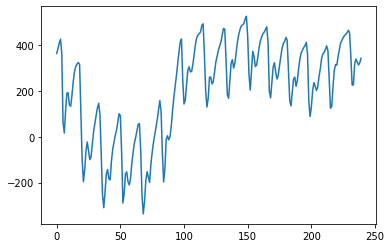

In [662]:
plt.plot(train.Data_2.iloc[0])

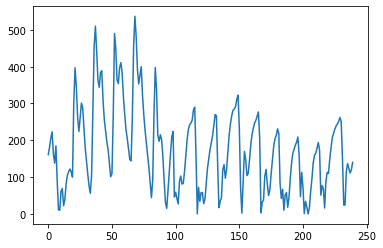

In [663]:
plt.plot(np.abs(train.Data_2.iloc[0] - train.Data_2.iloc[0].mean()))

In [664]:
train_sequences = train.groupby(['Filename', 'Test_index', 'Presentation']).idx.unique().reset_index()
train_sequences_labels = []

for i in range(train_sequences.shape[0]):
    train_sequences_labels.append(train.loc[train_sequences.idx[i], 'Class_label'].values)
    
train_sequences['labels'] = train_sequences_labels

In [676]:
sample_idxs = []
sample_labels = []

for i in track(range(train_sequences.shape[0])):
    indexes_ = np.random.choice(len(train_sequences.idx.iloc[i]), 3)
    sample_idxs.append(train_sequences.idx.iloc[i][indexes_])
    sample_labels.append(train_sequences.labels.iloc[i][indexes_])

 [████████████████████████████████████████████████████████████] 4685/4685 [00:00<00:00, 0.00s/it]

In [685]:
sample_labels = np.concatenate(sample_labels).reshape((len(sample_labels), 3))

# balanced train

In [677]:
train.Class_label.value_counts()

1    17642
2     7028
0     6713
Name: Class_label, dtype: int64

In [678]:
balanced_train = pd.concat([train[train.Class_label.isin([0, 2])],
                            train[train.Class_label == 1].sample(7000)], ignore_index=True)

balanced_train['idx'] = list(balanced_train.index)

In [679]:
balanced_train.Class_label.value_counts()

2    7028
1    7000
0    6713
Name: Class_label, dtype: int64

In [669]:
balanced_train['Data_max'] = balanced_train.Data.apply(lambda x: np.max(x))
balanced_train['Data_min'] = balanced_train.Data.apply(lambda x: np.min(x))
balanced_train['Data_2_max'] = balanced_train.Data_2.apply(lambda x: np.max(x) if len(x) > 0 else 0)
balanced_train['Data_2_min'] = balanced_train.Data_2.apply(lambda x: np.min(x) if len(x) > 0 else 0)

In [670]:
balanced_train = pd.merge(balanced_train.drop(['Data_max'], axis=1), 
                          balanced_train.groupby(['Filename', 'Test_index', 'Presentation']).Data_max.max().reset_index(), 
                          on=list(balanced_train.columns[:3]), how='left')

balanced_train = pd.merge(balanced_train.drop(['Data_min'], axis=1), 
                          balanced_train.groupby(['Filename', 'Test_index', 'Presentation']).Data_min.min().reset_index(), 
                          on=list(balanced_train.columns[:3]), how='left')

balanced_train = pd.merge(balanced_train.drop(['Data_2_max'], axis=1), 
                          balanced_train.groupby(['Filename', 'Test_index', 'Presentation']).Data_2_max.max().reset_index(), 
                          on=list(balanced_train.columns[:3]), how='left')

balanced_train = pd.merge(balanced_train.drop(['Data_2_min'], axis=1), 
                          balanced_train.groupby(['Filename', 'Test_index', 'Presentation']).Data_2_min.min().reset_index(), 
                          on=list(balanced_train.columns[:3]), how='left')

In [671]:
balanced_train.head(1)

,Filename,Test_index,Presentation,Question,Data,Data_2,Class_label,idx,Data_max,Data_min,Data_2_max,Data_2_min
0,00b38188-82ee-4f1d-9661-485338815751,0,1,1,"[345, 357, 367, 377, 360, 217, 150, 180, 216, ...","[362, 383, 407, 424, 364, 63, 16, 112, 190, 19...",2,0,628,-484,615,-853


In [672]:
balanced_train['Data_max'] = balanced_train['Data_max'].max()
balanced_train['Data_min'] = balanced_train['Data_min'].min()
balanced_train['Data_2_max'] = balanced_train['Data_2_max'].max()
balanced_train['Data_2_min'] = balanced_train['Data_2_min'].min()

In [673]:
balanced_train['Data'] = balanced_train.apply(lambda x: (x[4] - x[9]) / (x[8] - x[9]), axis=1)
balanced_train['Data_2'] = balanced_train.apply(lambda x: (x[5] - x[11]) / (x[10] - x[11]), axis=1)

# make data

In [680]:
data1 = []
for idx in track(sample_idxs):
    temp = np.concatenate(train.Data.iloc[idx].values, axis=0)
    if len(temp) < 720:
        fill_temp = np.zeros((720-len(temp)))
        fill_temp[...] = np.mean(temp)
        temp = np.hstack([temp, fill_temp])
    data1.append(temp)
    
data2 = []
for idx in track(sample_idxs):
    temp = np.concatenate(train.Data_2.iloc[idx].values, axis=0)
    if len(temp) < 720:
        fill_temp = np.zeros((720-len(temp)))
        fill_temp[...] = np.mean(temp)
        temp = np.hstack([temp, fill_temp])
    data2.append(temp)

 [████████████████████████████████████████████████████████████] 4685/4685 [00:00<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 4685/4685 [00:00<00:00, 0.00s/it]

/Users/neiro/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/neiro/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [681]:
data1 = np.concatenate(data1).reshape((len(data1), 720))
data2 = np.concatenate(data2).reshape((len(data1), 720))

In [682]:
data = np.concatenate([data1[..., np.newaxis], data2[..., np.newaxis]], axis=2)

In [686]:
labels = sample_labels[:, 1]

# feature engineering

In [426]:
# data = np.concatenate([data1.to_numpy()[..., np.newaxis], 
#                        data2.to_numpy()[..., np.newaxis]], axis=2)

In [697]:
data1_cumsum = np.cumsum(data1, axis=1)
data2_cumsum = np.cumsum(data2, axis=1)

In [702]:
deriv_shifts = [3, 7, 15, 31, 63]
derivs1 = []

for ds in deriv_shifts:

    deriv = data1[:, :-ds] - data1[:, ds:]
    values_to_fill = data1.shape[1] - deriv.shape[1]
    deriv = np.hstack([deriv, np.zeros((data1.shape[0], values_to_fill))])
    
    derivs1.append(deriv)

In [703]:
deriv_shifts = [3, 7, 15, 31, 63]
derivs2 = []

for ds in deriv_shifts:

    deriv = data2[:, :-ds] - data2[:, ds:]
    values_to_fill = data2.shape[1] - deriv.shape[1]
    deriv = np.hstack([deriv, np.zeros((data2.shape[0], values_to_fill))])
    
    derivs2.append(deriv)

In [704]:
# windows = [3, 7, 15, 31, 63]

# rolling_windows_sum_1 = []
# rolling_windows_mean_1 = []
# rolling_windows_max_1 = []
# rolling_windows_min_1 = []

# rolling_windows_sum_2 = []
# rolling_windows_mean_2 = []
# rolling_windows_max_2 = []
# rolling_windows_min_2 = []

# for window in track(windows):
    
#     rolling_windows_sum_1.append(data1.rolling(window, axis=1).sum().fillna(0).to_numpy())
#     rolling_windows_mean_1.append(data1.rolling(window, axis=1).mean().fillna(0).to_numpy())
#     rolling_windows_max_1.append(data1.rolling(window, axis=1).max().fillna(0).to_numpy())
#     rolling_windows_min_1.append(data1.rolling(window, axis=1).min().fillna(0).to_numpy())
    
#     rolling_windows_sum_2.append(data2.rolling(window, axis=1).sum().fillna(0).to_numpy())
#     rolling_windows_mean_2.append(data2.rolling(window, axis=1).mean().fillna(0).to_numpy())
#     rolling_windows_max_2.append(data2.rolling(window, axis=1).max().fillna(0).to_numpy())
#     rolling_windows_min_2.append(data2.rolling(window, axis=1).min().fillna(0).to_numpy())

In [705]:
data = np.concatenate([
    data,
    data1_cumsum[..., np.newaxis],
    data2_cumsum[..., np.newaxis],
], axis=2)

In [706]:
for deriv in derivs1:
    data = np.concatenate([
        data,
        deriv[..., np.newaxis],
    ], axis=2)

In [707]:
for deriv in derivs2:
    data = np.concatenate([
        data,
        deriv[..., np.newaxis],
    ], axis=2)

In [708]:
# for rw_ in track([rolling_windows_sum_1, rolling_windows_mean_1, 
#                   rolling_windows_max_1, rolling_windows_min_1,
#                   rolling_windows_sum_2, rolling_windows_mean_2,
#                   rolling_windows_max_2, rolling_windows_min_2]):

#     for rw in rw_:
#         data = np.concatenate([
#             data,
#             rw[..., np.newaxis],
#         ], axis=2)

In [709]:
data.shape

(4685, 720, 14)

# prepare data for pair-training 

In [436]:
train.groupby(['Filename', 'Presentation']).idx.count().max()

53

In [437]:
train.groupby(['Filename', 'Test_index', 'Presentation']).idx.shift(13).notnull().sum()

8

In [438]:
pair1_ = []
pair2_ = []

labels_ = []

for i in range(-13, 14, 1):
    
    if i != 0:
    
        temp = balanced_train.groupby(['Filename', 'Test_index', 'Presentation']).idx.shift(i)
        
        if temp.shape[0] > 0:
            
            pair1_.extend(list(balanced_train[temp.notnull()].idx))
            pair2_.extend(list(temp[temp.notnull()].values))
            
            labels_.extend(list(balanced_train[temp.notnull()].Class_label))

In [439]:
assert len(pair1) == len(pair2) == len(labels)

In [440]:
len(pair1)

10000

In [441]:
pair1 = np.array(pair1_, dtype=int)[:10000]
pair2 = np.array(pair2_, dtype=int)[:10000]
labels = np.array(labels_, dtype=int)[:10000]

In [442]:
len(pair1)

10000

# build 2 outputs model

In [130]:
from tensorflow import keras
from tensorflow.keras import layers

In [131]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    
    return x + res

In [159]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inp1 = keras.Input(shape=input_shape)
    inp2 = keras.Input(shape=input_shape)
    
    x12 = []
    
    for inputs in [inp1, inp2]:
    
        x = inputs
        
        x = layers.Conv1D(32, 3, activation='relu', input_shape=(240, 2))(x)
        x = layers.Conv1D(16, 3, activation='relu')(x)
        x = layers.Conv1D(8, 3, activation='relu')(x)
        x = layers.AveragePooling1D()(x)
        # x = layers.Flatten()(x)
        
        for _ in range(num_transformer_blocks):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
        x12.append(x)
    
    x = layers.concatenate(x12, axis=-1)
    
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    output1 = layers.Dense(3, activation="softmax", name='classification')(x)
    output2 = layers.Dense(1, activation="softmax", name='regression')(x)
    
    return keras.Model([inp1, inp2], [output1, output2])

In [164]:
input_shape = data.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=256,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[128],
#     mlp_dropout=0.4,
#     dropout=0.25,
# )

model.compile(
    loss={'classification': 'sparse_categorical_crossentropy', 
          'regression': 'mean_squared_error'},
    loss_weights={'classification': 1.0, 'regression': 1.0},
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics={'classification': 'sparse_categorical_accuracy', 'regression': 'mean_absolute_error'},
)
model.summary()

checkpoint_path = 'models/best.h5'

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=3, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, 
                                    verbose=1, save_best_only=True, save_weights_only=False)
]

model.fit(
    [data[pair1], data[pair2]],
    [labels, labels / 2],
    validation_split=0.15,
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 240, 58)]    0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 240, 58)]    0           []                               
                                                                                                  
 conv1d_322 (Conv1D)            (None, 238, 32)      5600        ['input_35[0][0]']               
                                                                                                  
 conv1d_333 (Conv1D)            (None, 238, 32)      5600        ['input_36[0][0]']               
                                                                                           

2022-07-16 19:31:35.724585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 1.3183 - classification_loss: 0.9771 - regression_loss: 0.3412 - classification_sparse_categorical_accuracy: 0.5800 - regression_mean_absolute_error: 0.4863

2022-07-16 19:38:00.822026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.29564, saving model to models/best.h5
67/67 [==============================] - 421s 6s/step - loss: 1.3183 - classification_loss: 0.9771 - regression_loss: 0.3412 - classification_sparse_categorical_accuracy: 0.5800 - regression_mean_absolute_error: 0.4863 - val_loss: 1.2956 - val_classification_loss: 0.9575 - val_regression_loss: 0.3382 - val_classification_sparse_categorical_accuracy: 0.5900 - val_regression_mean_absolute_error: 0.4857 - lr: 1.0000e-05
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 1.3148 - classification_loss: 0.9736 - regression_loss: 0.3412 - classification_sparse_categorical_accuracy: 0.5805 - regression_mean_absolute_error: 0.4863
Epoch 2: val_loss improved from 1.29564 to 1.29498, saving model to models/best.h5
67/67 [==============================] - 350s 5s/step - loss: 1.3148 - classification_loss: 0.9736 - regression_loss: 0.3412 - classification_sparse_categorical_accuracy: 0.5805 - regression

KeyboardInterrupt: 

In [170]:
pair1_test = np.array(pair1_, dtype=int)[10000:15000]
pair2_test = np.array(pair2_, dtype=int)[10000:15000]
labels_test = np.array(labels_, dtype=int)[10000:15000]

In [171]:
model.evaluate(
    [data[pair1_test], data[pair2_test]],
    [labels_test, labels_test / 2], 
    verbose=1
)

157/157 [==============================] - 78s 473ms/step - loss: 1.3376 - classification_loss: 0.9875 - regression_loss: 0.3501 - classification_sparse_categorical_accuracy: 0.5612 - regression_mean_absolute_error: 0.4904


[1.3376017808914185,
 0.9875016808509827,
 0.35010001063346863,
 0.5612000226974487,
 0.4904000163078308]

In [179]:
filenames_unique = train.iloc[pair1_test].Filename.unique()

In [209]:
class_preds = []
regr_preds = []

for filename in track(filenames_unique):
    
    indxs = np.where(pd.Series(pair1_test).isin(train[train.Filename == filename].index.values))[0]
    preds = model.predict([data[pair1_test[indxs]], data[pair2_test[indxs]]])
    class_pred = np.mean(preds[0], axis=0)
    class_pred = np.where(class_pred == class_pred.max())[0][0]
    regr_pred = np.mean(preds[1])
    
    class_preds.append(class_pred)
    regr_preds.append(regr_pred)

 [████████████████████████████████████████████████████████████] 377/377 [02:59<00:00, 0.47s/it]

In [215]:
preds

[array([[0.19635858, 0.5662945 , 0.23734692],
        [0.19532153, 0.56761634, 0.23706213],
        [0.20203047, 0.56013244, 0.23783715],
        [0.20056798, 0.56482655, 0.23460552]], dtype=float32),
 array([[1.],
        [1.],
        [1.],
        [1.]], dtype=float32)]

In [213]:
train.Class_label.value_counts()

1    17642
2     7028
0     6713
Name: Class_label, dtype: int64

# build classification model

In [710]:
from tensorflow import keras
from tensorflow.keras import layers

In [711]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    
    return x + res

In [717]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    
    x = inputs
        
    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.Conv1D(16, 3, activation='relu')(x)
    x = layers.Conv1D(8, 3, activation='relu')(x)
    x = layers.AveragePooling1D()(x)
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    output1 = layers.Dense(3, activation="softmax", name='classification')(x)
    
    return keras.Model(inputs, output1)

In [718]:
data.shape

(4685, 720, 14)

In [720]:
input_shape = data.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics='sparse_categorical_accuracy',
)
# model.summary()

checkpoint_path = 'models/classification_best.h5'

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=3, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, 
                                    verbose=1, save_best_only=True, save_weights_only=False)
]

model.fit(
    data,
    labels,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/100


2022-07-17 04:25:11.560330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 192.4748 - sparse_categorical_accuracy: 0.4714

2022-07-17 04:32:17.581056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.01018, saving model to models/classification_best.h5
63/63 [==============================] - 461s 7s/step - loss: 192.4748 - sparse_categorical_accuracy: 0.4714 - val_loss: 1.0102 - val_sparse_categorical_accuracy: 0.5434 - lr: 1.0000e-04
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 1.0326 - sparse_categorical_accuracy: 0.5221
Epoch 2: val_loss did not improve from 1.01018
63/63 [==============================] - 415s 7s/step - loss: 1.0326 - sparse_categorical_accuracy: 0.5221 - val_loss: 1.0185 - val_sparse_categorical_accuracy: 0.5434 - lr: 1.0000e-04
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 1.0279 - sparse_categorical_accuracy: 0.5372 
Epoch 3: val_loss did not improve from 1.01018
63/63 [==============================] - 2895s 47s/step - loss: 1.0279 - sparse_categorical_accuracy: 0.5372 - val_loss: 1.0148 - val_sparse_categorical_accuracy: 0.5434 - lr: 1.0000e-04
Epoch 4/100
63/63 [====

KeyboardInterrupt: 

# Test inference

In [736]:
test = pd.read_excel('dataset_train.xlsx')
test.Data = test.Data.apply(lambda x: np.array(ast.literal_eval(x)))
test.Data_2 = test.Data_2.apply(lambda x: np.array(ast.literal_eval(x)))
test['idx'] = list(test.index)
test_sequences = test.groupby(['Filename', 'Test_index', 'Presentation']).idx.unique().reset_index()

sample_ = []
sample_idxs = []

for i in range(train_sequences.shape[0]):
    for j in train_sequences.idx.iloc[i]:
        indexes_ = np.random.choice(len(train_sequences.idx.iloc[i]), 3)
        sample_.append(j)
        sample_idxs.append(train_sequences.idx.iloc[i][indexes_])

data1 = []
for idx in sample_idxs:
    temp = np.concatenate(test.Data.iloc[idx].values, axis=0)
    if len(temp) < 720:
        fill_temp = np.zeros((720-len(temp)))
        fill_temp[...] = np.mean(temp)
        temp = np.hstack([temp, fill_temp])
    data1.append(temp)
    
data2 = []
for idx in sample_idxs:
    temp = np.concatenate(test.Data_2.iloc[idx].values, axis=0)
    if len(temp) < 720:
        fill_temp = np.zeros((720-len(temp)))
        fill_temp[...] = np.mean(temp)
        temp = np.hstack([temp, fill_temp])
    data2.append(temp)

data1 = np.concatenate(data1).reshape((len(data1), 720))
data2 = np.concatenate(data2).reshape((len(data1), 720))
data = np.concatenate([data1[..., np.newaxis], data2[..., np.newaxis]], axis=2)

data1_cumsum = np.cumsum(data1, axis=1)
data2_cumsum = np.cumsum(data2, axis=1)

deriv_shifts = [3, 7, 15, 31, 63]
derivs1 = []

for ds in deriv_shifts:

    deriv = data1[:, :-ds] - data1[:, ds:]
    values_to_fill = data1.shape[1] - deriv.shape[1]
    deriv = np.hstack([deriv, np.zeros((data1.shape[0], values_to_fill))])
    
    derivs1.append(deriv)
    
deriv_shifts = [3, 7, 15, 31, 63]
derivs2 = []

for ds in deriv_shifts:

    deriv = data2[:, :-ds] - data2[:, ds:]
    values_to_fill = data2.shape[1] - deriv.shape[1]
    deriv = np.hstack([deriv, np.zeros((data2.shape[0], values_to_fill))])
    
    derivs2.append(deriv)
    
data = np.concatenate([
    data,
    data1_cumsum[..., np.newaxis],
    data2_cumsum[..., np.newaxis],
], axis=2)

for deriv in derivs1:
    data = np.concatenate([
        data,
        deriv[..., np.newaxis],
    ], axis=2)
    
for deriv in derivs2:
    data = np.concatenate([
        data,
        deriv[..., np.newaxis],
    ], axis=2)

In [742]:
data.shape

(31383, 720, 14)

In [ ]:
test_preds = model.predict(data)

2022-07-17 08:33:31.691862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
test_preds_binary = []
for pred in test_preds:
    test_preds_binary.append(np.where(pred == pred.max())[0][0])

In [ ]:
sub = pd.read_csv('Назва

In [ ]:
sub['Class_label'] = test_preds_binary

In [ ]:
sub.to_csv('Московские Зайцы.csv', index=False)